In [1]:
cd ../../

/workspaces/research/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.war_exp.cv import nested_cv_fit, cv_fit, bootstrap_fit

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")
bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / "low-pass=1000Hz-downsample=500"
)

# subject identifiers
subject = "efri14"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [4]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


## Band-pass filter (70-200 Hz)

In [5]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname
epochs = mne.read_epochs(fpath, proj=False, preload=True)
hi_gamma = epochs.filter(l_freq=70, h_freq=200)
hi_gamma = hi_gamma.drop(unsuccessful_trial_inds)

# get shape of data
hi_gamma_data = hi_gamma.get_data()
ntrials, nchs, nsteps = hi_gamma_data.shape
print(f'epochs_data.shape = {hi_gamma_data.shape}')

Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/low-pass=1000Hz-downsample=500/efri14/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...     998.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
154 matching events found
No baseline correction applied
Setting up band-pass filter from 70 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 70.00
- Lower transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 95 samples (0.190 sec)

Dropped 26 epochs: 14, 16, 17, 20, 21, 27, 28, 29, 31, 33, 54, 63, 

In [6]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = hi_gamma_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


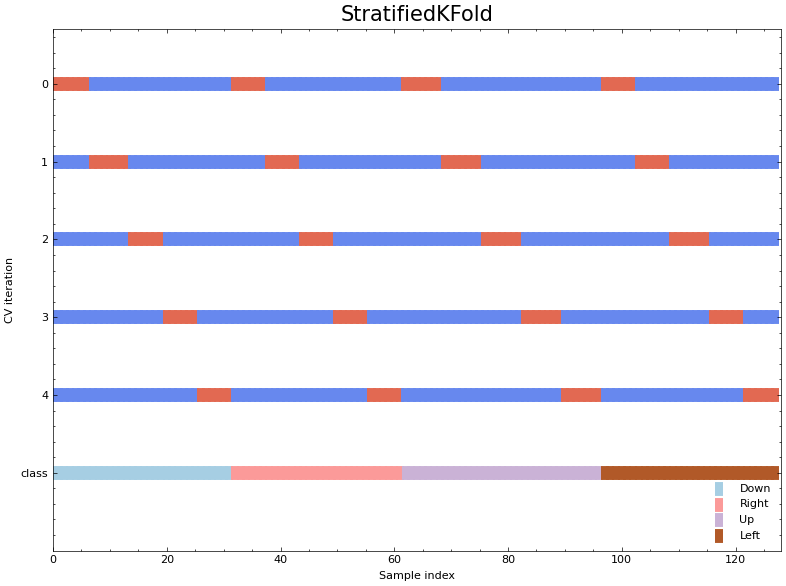

In [7]:
# Perform K-Fold cross validation
n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [8]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


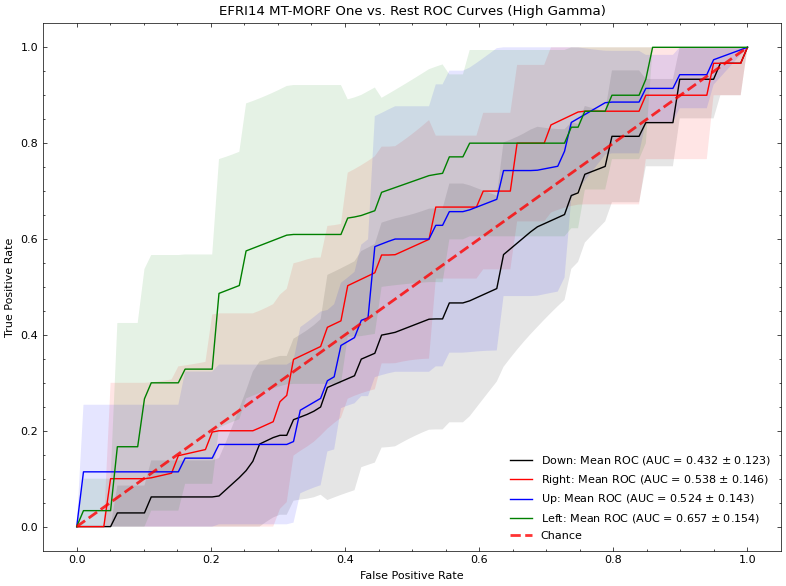

In [9]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (High Gamma)",
)
ax.legend(loc="lower right")
fig.tight_layout();

## Analyzing time-domain signal

In [6]:
# set time window
# tmin, tmax = (-0.5, 1.0)
tmin, tmax = (-0.75, 1.25)

# get EEG data
picks = []
epochs = read_dataset(
    bids_path,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    event_key="Left Target",
    notch_filter=True,
)

epochs.drop(unsuccessful_trial_inds)

epochs.load_data()

# Low-pass filter up to sfreq/2
fs = epochs.info["sfreq"]
epochs = epochs.filter(l_freq=None, h_freq=fs / 2 - 1)
# epochs = epochs.filter(l_freq=70, h_freq=200)

# Downsample epochs to 500 Hz
resample_rate = 500
epochs = epochs.resample(resample_rate)

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 163 trials, there were 154 successful trials in /workspaces/research/mnt/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading 0 ... 3773999  =      0.000 ...  1886.999 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper tra

In [7]:
drop_inds = {k : np.where(labels != k)[0] for k in np.unique(labels)}
label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

In [8]:
epochs_by_direction = {}
for k, v in drop_inds.items():
    tmp = epochs.copy()
    tmp.drop(v)
    epochs_by_direction[k] = tmp

Dropped 96 epochs: 0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27, 28, 32, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 94, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127
Dropped 98 epochs: 0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 68, 70, 71, 73, 74, 76, 77, 78, 79, 81, 83, 84, 86, 90, 91, 92, 93, 95, 96, 97, 98, 102, 103, 104, 105, 106, 107, 108, 111, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127
Dropped 93 epochs: 1, 2, 3, 4, 5, 7, 9, 10, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 37, 41, 42, 44, 45, 46, 49, 52, 54, 56, 5

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


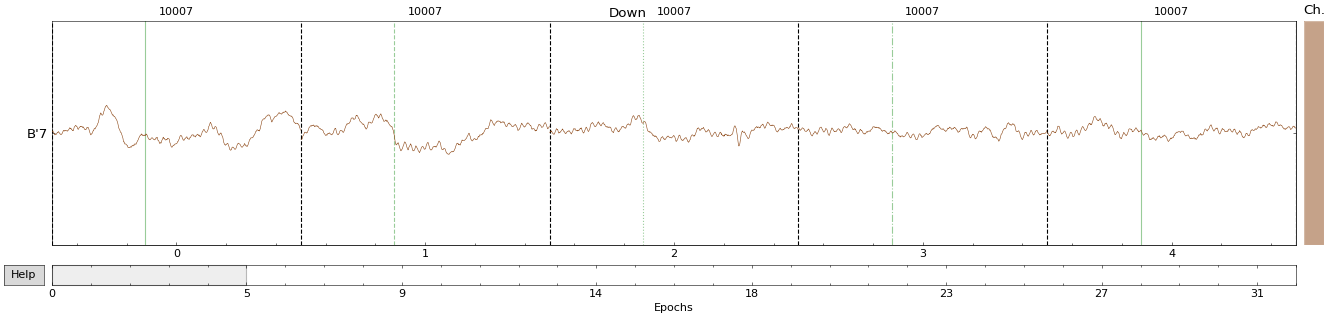

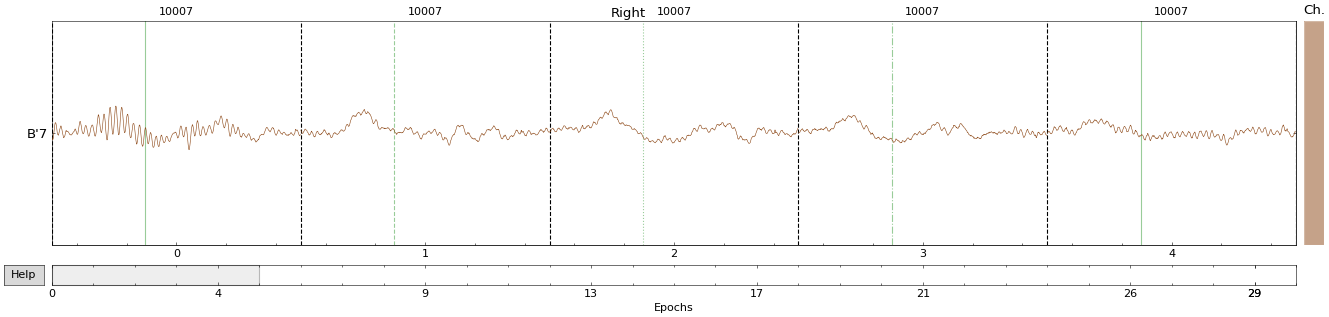

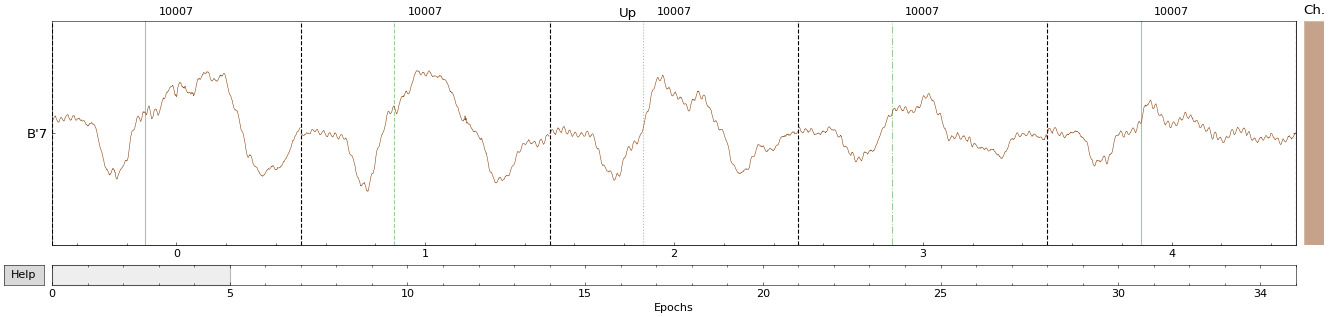

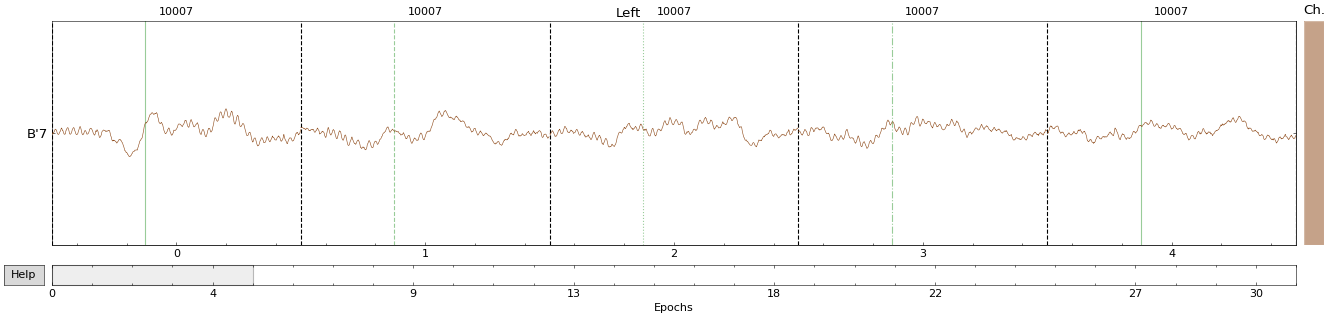

In [9]:
picks = ["B'7"]
for k, ep in epochs_by_direction.items():
    fig = ep.plot(
        picks=picks,
        scalings=dict(seeg=1e2), 
        n_epochs=5,
        show=False,
        title=label_names[k],
    )
    fig.suptitle(label_names[k])
    fig.set_size_inches(18, 4, forward=True)
    plt.show()

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


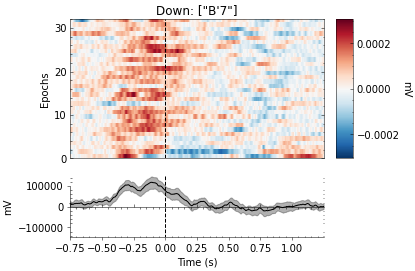

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


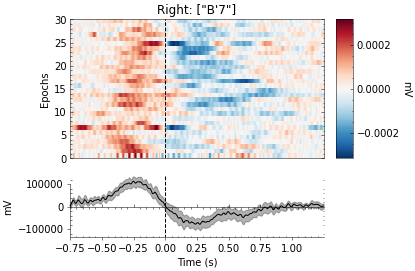

Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


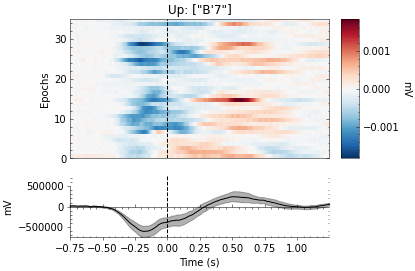

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


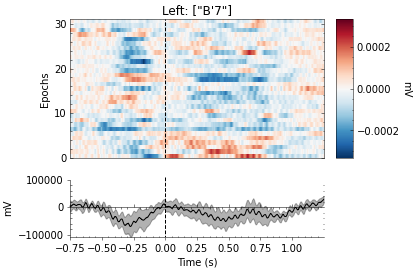

In [10]:
picks = ["B'7"]

# fig, axs = plt.subplots(nrows=3, ncols=4, dpi=100)

for i, (k, ep) in enumerate(epochs_by_direction.items()):
    ep.plot_image(
        picks=picks,
        scalings=dict(seeg=1e-6),
        title=f"{label_names[k]}: {picks}"
    );
plt.show()

## Running on Power for 70-200Hz

In [11]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


In [15]:
hi_gamma = power.data

hi_gamma.shape

(128, 81, 10, 334)

### Train on median frequency

In [18]:
median_freq_data = hi_gamma[:, :, nfreqs//2]

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
median_freq_data = median_freq_data[:, :, times]

median_freq_data.shape

(128, 81, 250)

In [40]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = median_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

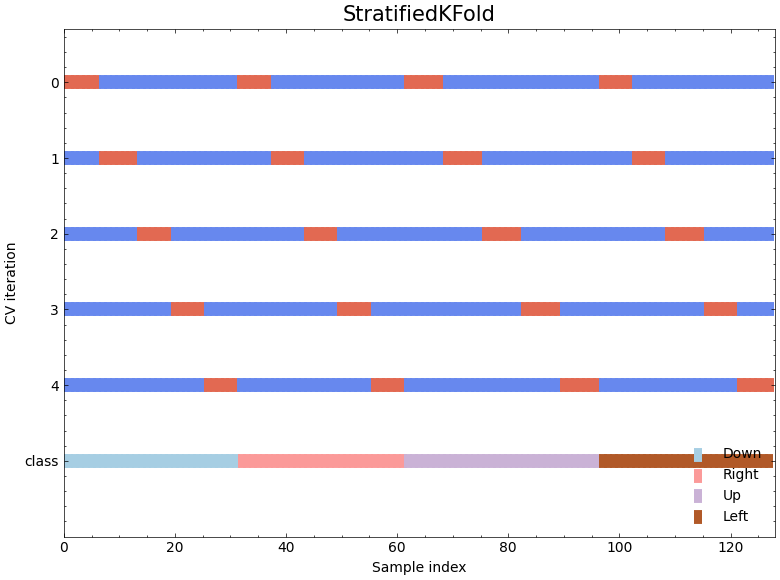

In [41]:
# Perform K-Fold cross validation
n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [42]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=median_freq_data.shape[1],
    image_width=median_freq_data.shape[2],
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

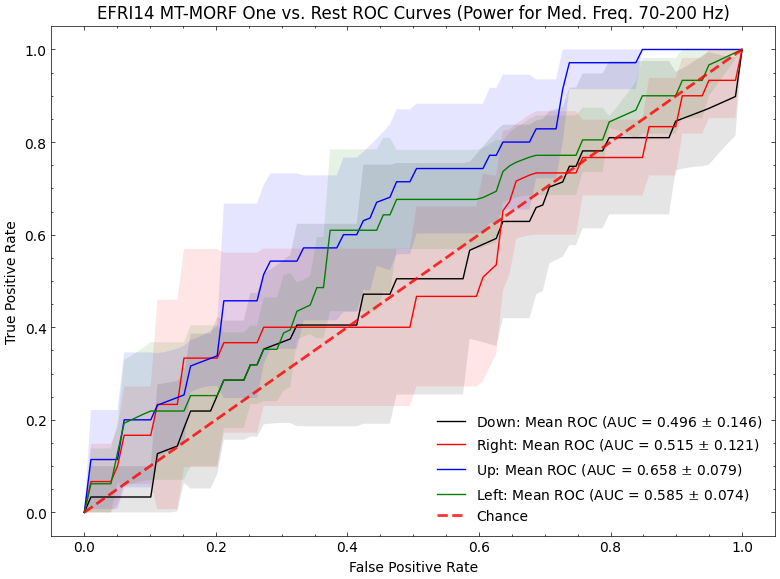

In [43]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power for Med. Freq. 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

### Average across freqs

In [44]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

avg_freq_data.shape

(128, 81, 250)

In [45]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

In [46]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

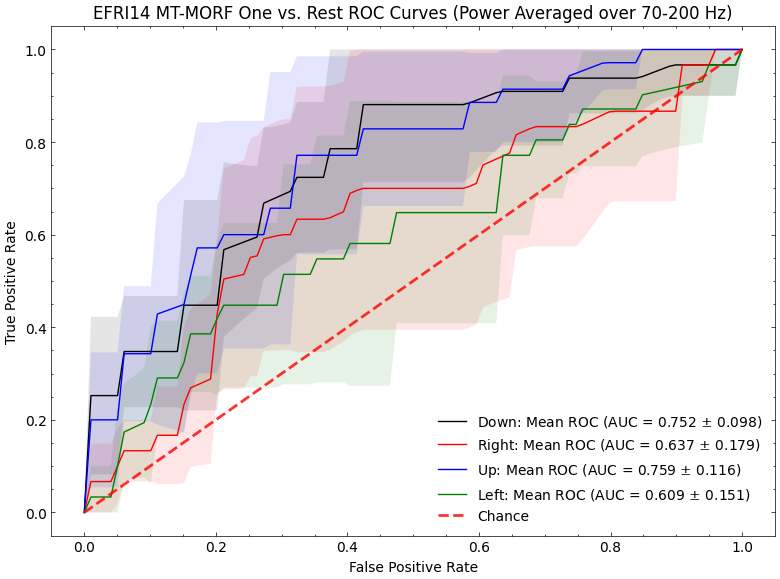

In [47]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

### Increase granularity of freq dimension

In [48]:
nfreqs = 30
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


In [49]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

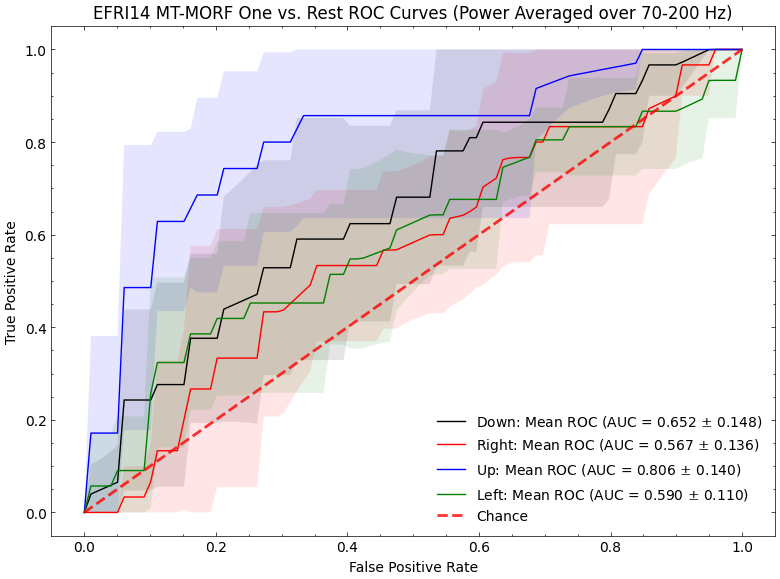

In [50]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

### Shrinking freq range to 70-150 Hz

In [52]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 150]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


In [53]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

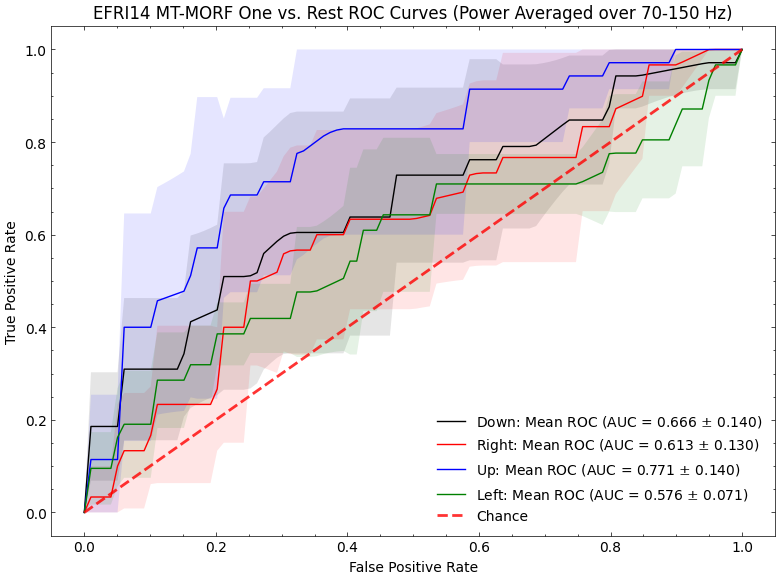

In [54]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-150 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();